# Firts attempts & Base Model

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline
#%pylab inline
import itertools
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [2]:
path_project = Path.home() / Path('Google Drive/Felix')
path_data = path_project / Path("data")
path_dump = path_project / Path("dump")

In [3]:
# loading cdv data
file = path_data / Path("felix.csv")
with Path.open(file, 'rb') as fp:
    cdv = pd.read_csv(fp,  encoding='cp1252',low_memory=False)

In [4]:
# loadind cdv data without format
file = path_data / Path("felix_ssfmt.csv")
with Path.open(file, 'rb') as fp:
    cdv_ssfmt = pd.read_csv(fp,  encoding='cp1252',low_memory=False)

## 1) Feature engineering

In [5]:
filename = path_dump / Path("dict_var_groups.sav")
with open(filename, 'rb') as fp:
     dict_var_groups = pickle.load(fp)

scope_2015_var = dict_var_groups['scope_2015_var']
scope_2016_var = dict_var_groups['scope_2016_var']
scope_2017_var = dict_var_groups['scope_2017_var']
scope_2018_var = dict_var_groups['scope_2018_var']
scope_2015_2018_var = dict_var_groups['scope_2015_2018_var']
scope_2016_2018_var = dict_var_groups['scope_2016_2018_var']
scope_2017_2018_var = dict_var_groups['scope_2017_2018_var']
pred_var = dict_var_groups['pred_var']
com_var = dict_var_groups['com_var']
tech_var = dict_var_groups['tech_var']
text_var = dict_var_groups['text_var']
bizz_var = dict_var_groups['bizz_var']
cat_var = dict_var_groups['cat_var']
cat_max9_var = dict_var_groups['cat_max9_var']
cat_min10_var = dict_var_groups['cat_min10_var']
quant_var = dict_var_groups['quant_var']

In [6]:
print(f"out of the {cdv.shape[1]} variable :")
print(f"{len(scope_2015_2018_var)} variables como, to all years ")

out of the 354 variable :
268 variables como, to all years 


In [7]:
exclusion = com_var | tech_var | bizz_var | text_var 
print(f"Out of the {len(scope_2015_2018_var)} variables comon to all years ")
print(f"{len(scope_2015_2018_var & exclusion)} are excluded ")
scope_2015_2018_var_kept = scope_2015_2018_var - exclusion
print(f"{len(scope_2015_2018_var_kept)} are kept ")

Out of the 268 variables comon to all years 
22 are excluded 
246 are kept 


In [8]:
print(f"out of the {len(scope_2015_2018_var_kept)} common variable :")
print(f"{len(cat_var & scope_2015_2018_var_kept)} variables are categorial ")
print(f"{len(quant_var & scope_2015_2018_var_kept)} variables are quantitative ")

out of the 246 common variable :
171 variables are categorial 
75 variables are quantitative 


In [9]:
print(f"out of the {len(cat_var & scope_2015_2018_var_kept)} variable categorial:")
print(f"{len(cat_max9_var & scope_2015_2018_var_kept)} variables have maximum 9 modalities  ")
print(f"{len(cat_min10_var & scope_2015_2018_var_kept)} variables have more and are excluded")
cat_var_kept = cat_max9_var & scope_2015_2018_var_kept

out of the 171 variable categorial:
156 variables have maximum 9 modalities  
15 variables have more and are excluded


In [10]:
scope_quant_var = (quant_var & scope_2015_2018_var_kept) 
quant_null = np.sum(cdv_ssfmt.loc[:,scope_quant_var].isnull())
quant_var_kept = set(quant_null[quant_null < 200].index)
print(f"out of the {len(scope_quant_var)} quantitatices variables:")
print(f"{len(quant_var_kept)} have less than 200 missing values and are kept")

out of the 75 quantitatices variables:
60 have less than 200 missing values and are kept


In [11]:
scope = cat_var_kept | quant_var_kept
df = cdv_ssfmt.loc[:,scope]
df.loc[:,cat_var_kept - {"HEUREUX"}] = cdv.loc[:,cat_var_kept - {"HEUREUX"}]

In [12]:
print(f"Number of variable kept {df.shape[1]}")

Number of variable kept 216


### Encoding 'HEUREUX'

In [13]:
# reducing problem to a 2 class classification problem
df["HEUREUX_CLF"] = 0
df.loc[df["HEUREUX"]==4, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==3, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==5, "HEUREUX_CLF"] = None

In [14]:
# Modelisation as a regression problem
df["HEUREUX_REG"] = df["HEUREUX"]
df.loc[df["HEUREUX"]==5, "HEUREUX_REG"] = None

### Encoding categorial variables

In [15]:
p = df.shape[1]
print(f"{p} columns")
print(f"out of which {len(cat_var_kept)-1} are corresponding to categorial features")

218 columns
out of which 155 are corresponding to categorial features


In [16]:
df = pd.get_dummies(df, 
                    columns=cat_var_kept - {"HEUREUX"},
                    dummy_na = True,
                    drop_first=1)

In [17]:
q = df.shape[1]
print(f"{q} columns after encoding")
print(f"{len(cat_var_kept)-1} variables where re-encoded in {len(cat_var_kept)-1+q-p}")

635 columns after encoding
155 variables where re-encoded in 572


In [18]:
def get_related_features(variable):
    '''return all columns in global variable df
    starting by variable'''
    if isinstance(variable, str):
        scope = {variable}
    else:
        scope = set(variable)
    features = set()
    for element in scope:
        features = features  | {c for c in df.columns if len(c) > len(element) 
                               and c[0:len(element)] == element 
                               and c[len(element)]=='_'}
    return features

## 2) Dataset construction and visualisation

In [19]:
features = df.columns.drop(['HEUREUX',"HEUREUX_CLF", "HEUREUX_REG"])
pred = "HEUREUX_CLF"

# treating remaining missing values
df_tmp = df.loc[:,set(features) | {pred} ].dropna()

X = df_tmp.loc[:,features]
y = df_tmp[pred]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 10596
- training set: 8476
- test set: 2120
Number of features: p=632
Number of class: 2
class 0 : 34.9%
class 1 : 65.1%


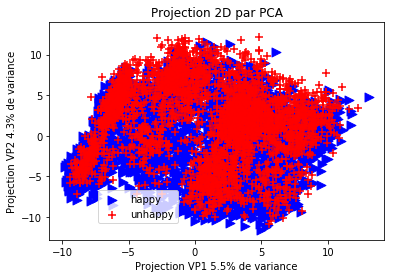

In [20]:
# Reduction dim PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_r = pca.transform(X_train)
happy = (y_train==1)
unhappy = (y_train==0)
plt.scatter(X_r[happy,0], X_r[happy,1], 
            s=80, c='blue',marker=">", label="happy")
plt.scatter(X_r[unhappy,0], X_r[unhappy,1], 
            s=80, c='red',marker='+', label="unhappy")
plt.ylabel(f'Projection VP2 \
{pca.explained_variance_ratio_[1]*100:0.1f}% de variance')
plt.xlabel(f'Projection VP1 \
{pca.explained_variance_ratio_[0]*100:0.1f}% de variance')
plt.title("Projection 2D par PCA") 
plt.legend(bbox_to_anchor=(0.4, 0.25))
plt.show()

## 3)  Baseline model 

**Logistic regression** with **4 features** to predict a **2 class** variable

In [21]:
features = {'ETATSAN','NOT_AMIS','DEPLOG','NOT_FAMI'}
pred = "HEUREUX_CLF"

# treating remaining missing values
df_tmp = df.loc[:,set(features) | {pred} ].dropna()

X = df_tmp.loc[:,features]
y = df_tmp[pred]


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 10915
- training set: 8732
- test set: 2183
Number of features: p=4
Number of class: 2
class 0 : 34.9%
class 1 : 65.1%


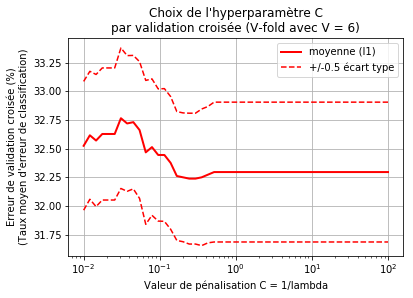

Détermination des paramètres optimaux en 23.4 s
Pénalisation l1, valeur optimale : C = 0.24


In [22]:
nb_value = 50 # Nombre de valeurs testées pour l'hyperparamètre
mean_score_l1 = np.zeros(nb_value)
C_log = np.logspace(-2,2,nb_value)
cv = 6 # V-fold, nombre de fold

mean_score_l1 = np.empty(nb_value)
std_scores_l1 = np.empty(nb_value)

np.random.seed(seed=42) 

startTime = time.time()

for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l1', 
                             tol=0.01, random_state=42, 
                             class_weight='balanced')
    mean_score_l1[i] = 100*np.mean(1-cross_val_score(clf, 
                                                     X_train, 
                                                     y_train,
                                                     cv=cv, 
                                                     scoring='accuracy'))
    std_scores_l1[i] = 100*np.std(1-cross_val_score(clf, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=cv, 
                                                    scoring='accuracy'))    


    
plt.figure()
plt.semilogx(C_log,mean_score_l1[:],'r',linewidth=2,label='moyenne (l1)')
plt.semilogx(C_log,mean_score_l1[:]-0.5*std_scores_l1[:],
             'r--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l1[:]+0.5*std_scores_l1[:],'r--')


plt.xlabel("Valeur de pénalisation C = 1/lambda")
plt.ylabel(u"Erreur de validation croisée (%)\n(Taux moyen d'erreur de classification)")
plt.title(u"Choix de l'hyperparamètre C\npar validation croisée \
(V-fold avec V = %s)" % (cv)) 
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()
print("Détermination des paramètres optimaux en %0.1f s" % (time.time() - startTime))
print("Pénalisation l1, valeur optimale : C = %0.2f" % (C_log[np.argmin(mean_score_l1)]))

In [23]:
# Learning on full training set with optimals hyperparameters 
# and score evaluation on test set
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l1)], 
                         penalty='l1', 
                         tol=0.01, 
                         random_state=42, 
                         class_weight='balanced')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
f1 = f1_score(y_test, y_test_pred)
print(f"- F1 score : {f1*100:0.1f} %")

Model score
- Accuracy : 67.1 %
- F1 score : 74.0 %


## 4) Feature selection

In [24]:
features = df.columns.drop(['HEUREUX',"HEUREUX_CLF", "HEUREUX_REG"])

# treating remaining missing values
print(f"{df.shape[0]} exemples before droping na")
df_tmp = df.loc[:,set(features) | {pred} ].dropna()

X = df_tmp.loc[:,features]
y = df_tmp[pred]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

11131 exemples before droping na
Number exemple: 10596
- training set: 8476
- test set: 2120
Number of features: p=632
Number of class: 2
class 0 : 34.9%
class 1 : 65.1%


### a) RFECV using lasso

Optimal number of features : 105


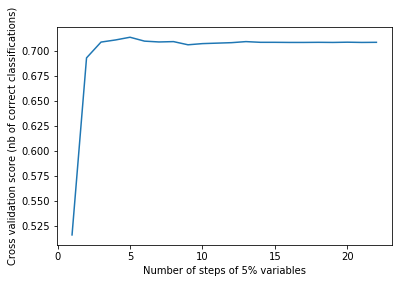

Détermination des features optimales en 379.6 s


In [25]:
startTime = time.time()

clf = LogisticRegression(C=1, 
                         penalty='l1', 
                         class_weight='balanced',
                         random_state=42)

rfecv = RFECV(estimator=clf, step=0.05, cv=StratifiedKFold(2),
              scoring='accuracy')

rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of steps of 5% variables")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
print("Détermination des features optimales en %0.1f s" % (time.time() - startTime))

Using slected features to fit various models

In [26]:
lasso_mask = rfecv.support_.copy()
X_train = X_train[:,lasso_mask]
X_test = X_test[:,lasso_mask]
print(f"Number of features: p={X_train.shape[1]}")

Number of features: p=105


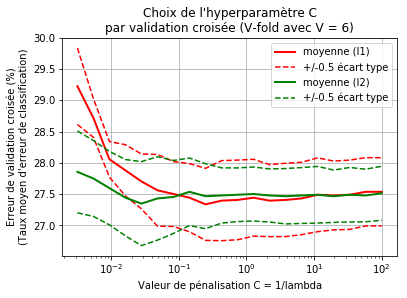

Détermination des paramètres optimaux en 107.5 s
Pénalisation l1, valeur optimale : C = 0.25
Pénalisation l2, valeur optimale : C = 0.03


In [27]:
nb_value = 20 # Nombre de valeurs testées pour l'hyperparamètre
mean_score_l1 = np.zeros(nb_value)
mean_score_l2 = np.zeros(nb_value)
C_log = np.logspace(-2.5,2,nb_value)
cv = 6 # V-fold, nombre de fold

mean_score_l1 = np.empty(nb_value)
std_scores_l1 = np.empty(nb_value)

mean_score_l2 = np.empty(nb_value)
std_scores_l2 = np.empty(nb_value)

np.random.seed(seed=42) 

startTime = time.time()

for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l1', 
                             tol=0.01, random_state=42, 
                             class_weight='balanced')
    mean_score_l1[i] = 100*np.mean(1-cross_val_score(clf, 
                                                     X_train, 
                                                     y_train,
                                                     cv=cv, 
                                                     scoring='accuracy'))
    std_scores_l1[i] = 100*np.std(1-cross_val_score(clf, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=cv, 
                                                    scoring='accuracy'))    


for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l2', tol=0.01, random_state=42, class_weight='balanced')
    mean_score_l2[i] = 100*np.mean(1-cross_val_score(clf, 
                                                     X_train, 
                                                     y_train, 
                                                     cv=cv, 
                                                     scoring='accuracy'))
    std_scores_l2[i] = 100*np.std(1-cross_val_score(clf, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=cv, 
                                                    scoring='accuracy'))    
    
plt.figure()
plt.semilogx(C_log,mean_score_l1[:],'r',linewidth=2,label='moyenne (l1)')
plt.semilogx(C_log,mean_score_l1[:]-0.5*std_scores_l1[:],
             'r--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l1[:]+0.5*std_scores_l1[:],'r--')

plt.semilogx(C_log,mean_score_l2[:],'g',linewidth=2,label='moyenne (l2)')
plt.semilogx(C_log,mean_score_l2[:]-0.5*std_scores_l2[:], 'g--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l2[:]+0.5*std_scores_l2[:],'g--')

plt.xlabel("Valeur de pénalisation C = 1/lambda")
plt.ylabel(u"Erreur de validation croisée (%)\n(Taux moyen d'erreur de classification)")
plt.title(u"Choix de l'hyperparamètre C\npar validation croisée \
(V-fold avec V = %s)" % (cv)) 
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()
print("Détermination des paramètres optimaux en %0.1f s" % (time.time() - startTime))
print("Pénalisation l1, valeur optimale : C = %0.2f" % (C_log[np.argmin(mean_score_l1)]))
print("Pénalisation l2, valeur optimale : C = %0.2f" % (C_log[np.argmin(mean_score_l2)]))

In [28]:
# Learning on full training set with optimals hyperparameters 
# and score evaluation on test set
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l1)], 
                         penalty='l1', 
                         tol=0.01, 
                         random_state=42, 
                         class_weight='balanced')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
f1 = f1_score(y_test, y_test_pred)
print(f"- F1 score : {f1*100:0.1f} %")

Model score
- Accuracy : 72.1 %
- F1 score : 77.7 %


In [29]:
# Learning on full training set with optimals hyperparameters 
# and score evaluation on test set
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l2)], 
                         penalty='l2', 
                         tol=0.01, 
                         random_state=42, 
                         class_weight='balanced')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
f1 = f1_score(y_test, y_test_pred)
print(f"- F1 score : {f1*100:0.1f} %")

Model score
- Accuracy : 72.4 %
- F1 score : 78.0 %


In [30]:
startTime = time.time()
n_estimators_range = [16,32,64,128]
max_depth_range = [2,4,8,16,32,64,128,256] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)


params = {'max_features' :'sqrt', 'random_state' : 32, 'min_samples_split' : 2, 'class_weight' : 'balanced'}
clf = RandomForestClassifier(**params)

grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid)
grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \nAccuracy Score of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : grid.best_params_['n_estimators'],
          'max_depth' : grid.best_params_['max_depth']}
clf = RandomForestClassifier(**params).fit(X_train, y_train)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
print(f"... done in {time.time() - startTime:0.1f}")
print(f"Random Forest, p={X_train.shape[1]}")
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

Determination of optimal hyperparameters in 72.4 s
Optimal values are {'max_depth': 16, 'n_estimators': 64} 
Accuracy Score of cross valdation 74.04%
... done in 75.0
Random Forest, p=105
Model score
- Accuracy : 73.1 %
- F1 score : 80.9 %


In [31]:
touyrt
nb_value = 5 # Number of values tested for hyperparameter

C_log = np.logspace(-5,3,nb_value)
cv = 2 # V-fold, number of folds

params = { 'kernel' :'linear', 'class_weight' : 'balanced'}
clf = SVC(**params)


mean_score_1 = np.empty(nb_value)
std_scores_1 = np.empty(nb_value)

np.random.seed(seed=42) 
startTime = time.time()

for i, C in enumerate(C_log):
    params = { 'kernel' :'linear', 'C' : C, 'class_weight' : 'balanced'}
    clf = SVC(**params)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
    mean_score_1[i] = np.mean(scores)
    std_scores_1[i] = np.std(scores)  
                                                           
# Plotting cross validation score depending on alpha/c value
plt.figure()
plt.semilogx(C_log,mean_score_1[:],'r',linewidth=2,label='SVC average accuracy')
plt.semilogx(C_log,mean_score_1[:]-0.5*std_scores_1[:],'r--',
             label=u'+/-0.5 std dev.')
plt.semilogx(C_log,mean_score_1[:]+0.5*std_scores_1[:],'r--')

plt.xlabel("Regularisation coeficient $C$")
plt.ylabel("Accuracy\n")
plt.title(f"Support Vector Machine - linear kernel\nCross validation (V-fold with V={cv})") 
plt.legend(bbox_to_anchor=(1.5, 1))
plt.grid()
plt.show()
print(f"SVC optimisation in {time.time() - startTime:0.1f}")
print(f"Epsilon fixed at: {0.1:0.4f} \nOptimal value for C: {C_log[np.argmax(mean_score_1)]:0.4f}")
print(f"Corresponding accuracy : {100*np.max(mean_score_1):0.2f}%")

# Calculaltion of generalisation score
params = { 'kernel' :'linear', 'C' : C_log[np.argmax(mean_score_1)], 'class_weight' : 'balanced'}
# Learning on full training set with optimals hyperparameters and score on test set
clf = SVC(**params).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
print(f"... done in {time.time() - startTime:0.1f}")
print(f"SVM linear p={X_train.shape[1]}")
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

NameError: name 'touyrt' is not defined

In [ ]:
startTime = time.time()

nb_value = 4
C_log = np.logspace(-2,2,nb_value)
gamma_log = np.logspace(-4,0, nb_value)
param_grid = dict(C=C_log, gamma=gamma_log)

params = { 'kernel' :'rbf', 'class_weight' : 'balanced'}

clf = SVC(**params)
grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid)
grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \nAccuracy of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'kernel' :'rbf',
          'C' : grid.best_params_['C'], 
          "gamma" : grid.best_params_['gamma'],
          'class_weight' : 'balanced'}
clf = SVC(**params).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
print(f"... done in {time.time() - startTime:0.1f}")
print(f"SVM with Gaussian kernel, p={X_train.shape[1]}")
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

### a) RFECV using Random Forest

In [47]:
pred

'HEUREUX_CLF'

In [50]:
features = df.columns.drop(['HEUREUX',"HEUREUX_CLF", "HEUREUX_REG"])
pred = "HEUREUX_CLF"
# treating remaining missing values
print(f"{df.shape[0]} exemples before droping na")
df_tmp = df.loc[:,set(features) | {pred} ].dropna()

X = df_tmp.loc[:,features]
y = df_tmp[pred]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

11131 exemples before droping na
Number exemple: 10596
- training set: 8476
- test set: 2120
Number of features: p=632
Number of class: 2
class 0 : 34.9%
class 1 : 65.1%


Optimal number of features : 454


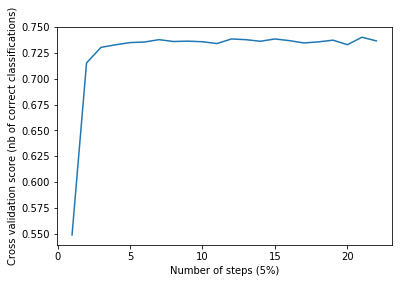

Détermination des features optimales en 222.2 s


In [36]:
startTime = time.time()
step = 0.05
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : 256,
          'max_depth' : 32}
clf = RandomForestClassifier(**params).fit(X_train, y_train)

rfecv = RFECV(estimator=clf, step=step , cv=StratifiedKFold(2),
              scoring='accuracy')

rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel(f"Number of steps ({step*100:0.0f}%)")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
print("Détermination des features optimales en %0.1f s" % (time.time() - startTime))

In [37]:
rf_mask = rfecv.support_.copy()
X_train = X_train[:,rf_mask]
X_test = X_test[:,rf_mask]
print(f"Number of features: p={X_train.shape[1]}")

Number of features: p=454


In [38]:
startTime = time.time()
n_estimators_range = [16,32,64,128,256]
max_depth_range = [2,4,8,16,32,64,128,256] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)


params = {'max_features' :'sqrt',
          'random_state' : 32,
          'min_samples_split' : 2,
          'class_weight' : 'balanced'
         }
clf = RandomForestClassifier(**params)

grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid)
grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \n\
Accuracy Score of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : grid.best_params_['n_estimators'],
          'max_depth' : grid.best_params_['max_depth']}
clf = RandomForestClassifier(**params).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
print(f"... done in {time.time() - startTime:0.1f}")
print(f"Random Forest, p={X_train.shape[1]}")
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

Determination of optimal hyperparameters in 270.4 s
Optimal values are {'max_depth': 16, 'n_estimators': 256} 
Accuracy Score of cross valdation 74.19%
... done in 279.9
Random Forest, p=454
Model score
- Accuracy : 73.5 %
- F1 score : 81.6 %


In [39]:
np.sum(rf_mask)

454

In [40]:
np.sum(lasso_mask)

105

In [51]:
len(rf_mask)

477

In [ ]:
len(lasso_mask)

### C) RFECV using SVM (linear kerner)

In [ ]:
features = df.columns.drop(['HEUREUX',"HEUREUX_CLF", "HEUREUX_REG"])

# treating remaining missing values
print(f"{df.shape[0]} exemples before droping na")
df_tmp = df.loc[:,set(features) | {pred} ].dropna()

X = df_tmp.loc[:,features]
y = df_tmp[pred]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

In [ ]:
startTime = time.time()

params = {'kernel' :'linear'}
clf = SVC(**params)

rfecv = RFECV(estimator=clf, step=0.2, cv=StratifiedKFold(2),
              scoring='accuracy')


rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

print("Détermination des features optimales en %0.1f s" % (time.time() - startTime))
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### Feature ranking ...

In [ ]:
# Use regression coefficients to rank features
clf = LogisticRegression(penalty='l2',C=0.4)
    
clf.fit(X_train,y_train)
coef_l2 = abs(clf.coef_)
coef_sorted_l2 = -np.sort(-coef_l2).reshape(-1)
print(coef_sorted_l2)
features_sorded_l2 = np.argsort(-coef_l2).reshape(-1)
print(features_sorded_l2)
features_name = np.array(features)
features_name_sorted_l2 = features_name[features_sorded_l2]
    
clf = LogisticRegression(penalty='l1',C=7.2)
    
clf.fit(X_train,y_train)
coef_l1 = abs(clf.coef_)
coef_sorted_l1 = -np.sort(-coef_l1).reshape(-1)
features_sorded_l1 = np.argsort(-coef_l1).reshape(-1)
features_name_sorted_l1 = features_name[features_sorded_l1]

nf = len(features)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ind = np.arange(nf)    # the x locations for the groups

plt.subplot(1, 2, 1)
p1 = plt.bar(ind, coef_sorted_l2[0:nf], 1, color='b',alpha=0.5)
plt.ylabel('Feature importance')
plt.title(u'Top %i features\nLogistic regression pénalisation l2 C = 0.4' % nf)
plt.xticks(ind + 0.35/2.0, features_name_sorted_l2[0:nf], rotation = 90)

plt.subplot(1, 2, 2)
p1 = plt.bar(ind, coef_sorted_l1[0:nf], 1, color='b',alpha=0.5)
plt.ylabel('Feature importance')
plt.title(u'Top %i features\nLogistic regression pénalisation l1 C = 7.2' % nf)
plt.xticks(ind + 0.35/2.0, features_name_sorted_l1[0:nf], rotation = 90)

plt.show()

In [ ]:
startTime = time.time()
n_estimators_range = [16,32,64,128]
max_depth_range = [2,4,8,16,32,64,128,256] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)


params = {'max_features' :'sqrt', 'random_state' : 32, 'min_samples_split' : 2, 'class_weight' : 'balanced'}
clf = RandomForestClassifier(**params)

grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid)
grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \nAccuracy Score of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : grid.best_params_['n_estimators'],
          'max_depth' : grid.best_params_['max_depth']}
clf = RandomForestClassifier(**params).fit(X_train, y_train)
y = clf.predict(X_test)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
print(f"... done in {time.time() - startTime:0.1f}")
print(f"Random Forest, p={X_train.shape[1]}")
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

## II) Multi class regression

In [56]:
features = df.columns.drop(['HEUREUX',"HEUREUX_CLF", "HEUREUX_REG"])
pred = "HEUREUX"

# treating remaining missing values
df_tmp = df.loc[:,set(features) | {pred} ]
df_tmp.loc[df_tmp["HEUREUX"]==5,"HEUREUX"]=None
df_tmp = df_tmp.dropna()

X = df_tmp.loc[:,features]
y = df_tmp[pred]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)


scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 10596
- training set: 8476
- test set: 2120
Number of features: p=632
Number of class: 4
class 1 : 1.8%
class 2 : 33.1%
class 3 : 49.1%
class 4 : 15.9%


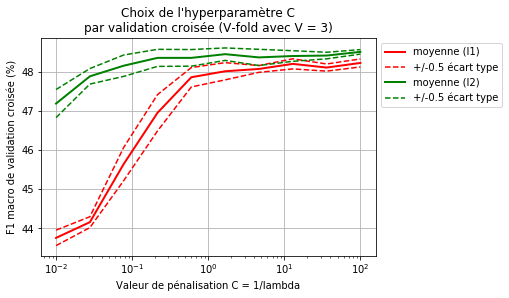

Détermination des paramètres optimaux en 5630.4 s
Pénalisation l1, valeur optimale : C = 100.0000
Pénalisation l2, valeur optimale : C = 100.0000


In [57]:
nb_value = 10 # Nombre de valeurs testées pour l'hyperparamètre
mean_score_l1 = np.zeros(nb_value)
mean_score_l2 = np.zeros(nb_value)
C_log = np.logspace(-2,2,nb_value)
cv = 3 # V-fold, nombre de fold

mean_score_l1 = np.empty(nb_value)
std_scores_l1 = np.empty(nb_value)

mean_score_l2 = np.empty(nb_value)
std_scores_l2 = np.empty(nb_value)

np.random.seed(seed=42) 

startTime = time.time()

for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l1', tol=0.01, random_state=42, class_weight='balanced')
    mean_score_l1[i] = 100*np.mean(1-cross_val_score(clf, 
                                                     X_train, 
                                                     y_train, 
                                                     cv=cv, 
                                                     scoring='f1_micro'))
    std_scores_l1[i] = 100*np.std(1-cross_val_score(clf, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=cv, 
                                                    scoring='f1_micro'))    


for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l2', tol=0.01, random_state=42, class_weight='balanced')
    mean_score_l2[i] = 100*np.mean(1-cross_val_score(clf, 
                                                     X_train, 
                                                     y_train, 
                                                     cv=cv, 
                                                     scoring='f1_micro'))
    std_scores_l2[i] = 100*np.std(1-cross_val_score(clf, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=cv, 
                                                    scoring='f1_micro'))    
    
plt.figure()
plt.semilogx(C_log,mean_score_l1[:],'r',linewidth=2,label='moyenne (l1)')
plt.semilogx(C_log,mean_score_l1[:]-0.5*std_scores_l1[:],
             'r--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l1[:]+0.5*std_scores_l1[:],'r--')

plt.semilogx(C_log,mean_score_l2[:],'g',linewidth=2,label='moyenne (l2)')
plt.semilogx(C_log,mean_score_l2[:]-0.5*std_scores_l2[:], 'g--',
             label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l2[:]+0.5*std_scores_l2[:],'g--')

plt.xlabel("Valeur de pénalisation C = 1/lambda")
plt.ylabel("F1 macro de validation croisée (%)")
plt.title(u"Choix de l'hyperparamètre C\npar validation croisée \
(V-fold avec V = %s)" % (cv)) 
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()
print(f"Détermination des paramètres optimaux en \
{time.time() - startTime:0.1f} s")
print(f"Pénalisation l1, valeur optimale : \
C = {C_log[np.argmax(mean_score_l1)]:0.4f}")
print(f"Pénalisation l2, valeur optimale : \
C = {C_log[np.argmax(mean_score_l2)]:0.4f}")

In [58]:
# Learning on full training set with optimals hyperparameters and score on test set
clf = LogisticRegression(C=C_log[np.argmax(mean_score_l2)], 
                         penalty='l2', 
                         tol=0.01, 
                         random_state=42, 
                         class_weight='balanced')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)


# Modelisation as a 5 multi class classification problem

class_names = ["Jamais",
               "Occasionnellement",
               "Assez souvent",
               "Très souvent" ]


Confusion matrix, without normalization
[[ 13  25   2   3]
 [ 52 362 234  54]
 [ 32 231 556 200]
 [ 14  42 138 162]]
Normalized confusion matrix
[[ 0.3   0.58  0.05  0.07]
 [ 0.07  0.52  0.33  0.08]
 [ 0.03  0.23  0.55  0.2 ]
 [ 0.04  0.12  0.39  0.46]]


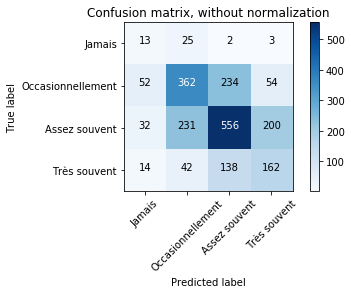

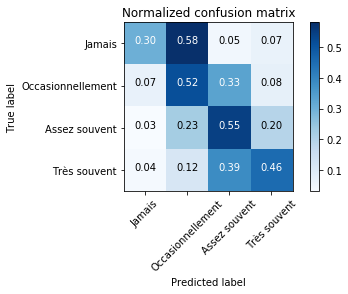

In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [108]:
f1_micro = f1_score(y_test, y_test_pred, average='micro')
f1_macro = f1_score(y_test, y_test_pred, average='macro')
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
acurracy = clf.score(X_test, y_test)
print(f"Score :\nf1 micro : {f1_micro*100:0.4f} %\nf1 macro : {f1_macro*100:0.4f} %\n\
f1 weighted : {f1_weighted*100:0.4f} %\nacurracy : {acurracy*100:0.4f} %")

Score :
f1 micro : 51.5566 %
f1 macro : 42.2254 %
f1 weighted : 52.3888 %
acurracy : 51.5566 %


In [78]:
# Recall 'jamais'
13/43

0.3023255813953488

In [79]:
# Recall 'Occasionnemmement'
362/(52+362+234+54)

0.5156695156695157

In [80]:
# Recall 'assez souvent'
556/(32+231+556+200)

0.5456329735034348

In [67]:
len(y_test)

2120

In [68]:
13+362+556+162

1093

In [71]:
# acurracy
1093/2120

0.5155660377358491

In [83]:
# average precision
c1 = 13 +25 + 2+  3
c2 = 52+362+234+ 54
c3 = 32+231+556+200
c4 = 14+ 42+138+162

In [84]:
print(c1,c2,c3,c4)

43 702 1019 356


In [85]:
print(len(y_test))

2120


In [91]:
c1 = 13 +25 + 2+  3
c2 = 52+362+234+ 54
c3 = 32+231+556+200
c4 = 14+ 42+138+162
print(c1,c2,c3,c4)
r1 = 13 / 43
r2 = 362 / 702
r3 = 556 / 1019
r4 = 162 / 366
print(f"{r1*100:0.2f}% {r2*100:0.2f}% {r3*100:0.2f}% {r4*100:0.2f}%")
p1 = 13 / (13+52+32+14)
p2 = 362 / (25 + 362 + 231 + 42)
p3 = 556 / (2 + 234 + 556 + 138)
p4 = 162 / (3 + 54 + 200 + 162)
print(f"{p1*100:0.2f}% {p2*100:0.2f}% {p3*100:0.2f}% {p4*100:0.2f}%")

43 702 1019 356
30.23% 51.57% 54.56% 44.26%
11.71% 54.85% 59.78% 38.66%


In [99]:
#average precision 
ap = ((13+52+32+14)*p1 + (25 + 362 + 231 + 42)*p2 +(2 + 234 + 556 + 138)*p3+ (3 + 54 + 200 + 162)*p4)/2120


ap = (43*p1 + 702*p2 +1019*p3+ 356*p4)/2120

In [100]:
#average recall 
ar = (43*r1 + 702*r2 +1019*r3+ 356*r4)/2120

In [101]:
2 * ap * ar / (ap+ar)

0.5246335808989457

In [107]:
f11 = 2*p1*r1/(p1+r1)
f12 = 2*p1*r2/(p2+r2)
f13 = 2*p3*r3/(p3+r3)
f14 = 2*p4*r4/(p4+r4)
print(f"{f11:0.4f} {f12:0.4f} {f13:0.4f} {f14:0.4f}")

0.1688 0.1135 0.5705 0.4127


In [106]:
(f11 + f12 + f13 + f14)/4

0.31640614947047796

In [109]:
(f11  + f13 + f14)/3

0.38403967394042327